# Clasificador binario con RandomForest del tipo de violencia "abuso y violencia".

Se tienen dos tipos "no tuvo violencia" y "abuso y violencia. Este último incluye a los de la categoría "ambos".

Sin preprocesamiento en el dataset. Todas las columnas se tratan como continuas aunque sean categóricas.

https://www.cienciadedatos.net/documentos/py08_random_forest_python.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=forest#sklearn.ensemble.RandomForestClassifier

In [1]:
import pandas as pd
from funciones import CargarPandasDatasetCategoricos, BorrarColumnas, InsertarColumnaNueva

In [2]:
# Custom functions
# ==============================================================================
from funciones import CargarPandasDataset

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from sklearn import tree #La versión que tengo es 0.24.1 y está disponible apartir de la 0.21

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, precision_recall_fscore_support, plot_confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
def escalar(df, scal):
    ind = df.index
    retail_scaler = pd.DataFrame(scal.fit_transform(df), index=ind)
    retail_scaler.columns = df.columns
    return retail_scaler, scal

In [5]:
def grid(param_grid, X, y):
    print(f'Creando modelos para {len(param_grid)} combinaciones de parámetros.\n')
    resultados = {'params': [], 'f1': []}
    importances = []
    
    #hacer grid search
    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1', verbose=1)
    
    #hacer fit
    grid.fit(X, y)
    
    #obtener parametros 
    resultados['params'].append(grid.best_params_)
    resultados['f1'].append(grid.best_score_)
    
    #hacer dataset con resultados
    resultados = pd.DataFrame(resultados)
    resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
    resultados = resultados.drop(columns = 'params')
    
    #obtener importancias
    importances = grid.best_estimator_.feature_importances_
    
    return resultados, importances

## Cargar datos

In [6]:
endireh = CargarPandasDatasetCategoricos('datasets/endireh.csv')

## Preprocesamiento


Solo nos quedamos con las que sufieron 'Abuso y violencia'.

Eliminando los de atención no autorizada

In [7]:
endireh.drop(endireh[endireh["P9_8"]==2].index, axis=0, inplace=True)

'abuso y violencia' y ambos sean 1.

In [8]:
endireh[endireh["P9_8"]>0] = 1

In [9]:
endireh.shape

(17485, 50)

Ninguno(0):	71%
Abuso y violencia(1):	29%


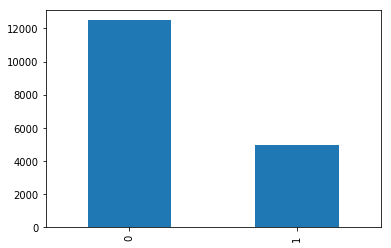

In [10]:
for i,j in zip(['Ninguno(0)', 'Abuso y violencia(1)'], endireh["P9_8"].value_counts()/endireh["P9_8"].value_counts().sum()):
    print(f'{i}:\t{round(j*100)}%')
endireh["P9_8"].value_counts().plot(kind='bar')

Obtengo la variable objetivo _y_.

In [11]:
y = endireh['P9_8'].copy()

Estandarizo

In [12]:
scalerMMS = MinMaxScaler() #StandardScaler
scalerSS  = StandardScaler()

In [13]:
df_MMS, scalerMMS = escalar(endireh, scalerMMS)
df_SS,  scalerSS  = escalar(endireh, scalerSS)

Al ser el análisis nacional borramos la variable _REGION_ que no pertenece a este estudio en particular y Elimino _y_ del dataset.

In [14]:
df_SS.drop(columns=['P9_8', 'REGION'], inplace=True)

In [15]:
df_MMS.drop(columns=['P9_8', 'REGION'], inplace=True)
#X_train, X_test, y_train, y_test = train_test_split(df_MMS, y, test_size=0.33, random_state=5)

In [16]:
endireh.drop(columns=['P9_8', 'REGION'], inplace=True)
#X_train, X_test, y_train, y_test = train_test_split(endireh, y, test_size=0.33, random_state=5)

## Encontrar los mejores parámetros con _Random Forest_

Poco antes de las 6 pm 2 de marzo de 2022

### STANDARDSCALER


In [17]:
param_grid = ParameterGrid(
                {
                 'n_estimators'      : [range(120, 390, 25)],
                 'criterion'         : [['gini', 'entropy']],
                 'min_samples_split' : [range(285, 580, 25)],
                 'min_samples_leaf'  : [range(150, 200, 2)],
                 'max_depth'         : [[6]],
                 'random_state'      : [[5]],
                }
            )


In [18]:
%time resultados, importances = grid(param_grid, df_SS, y)

Creando modelos para 1 combinaciones de parámetros.

Fitting 5 folds for each of 6600 candidates, totalling 33000 fits
CPU times: user 6h 19min 1s, sys: 43.9 s, total: 6h 19min 45s
Wall time: 6h 19min 45s


In [19]:
resultados.head(7)

,f1,criterion,max_depth,min_samples_leaf,min_samples_split,n_estimators,random_state
0,1.0,gini,6,150,285,120,5


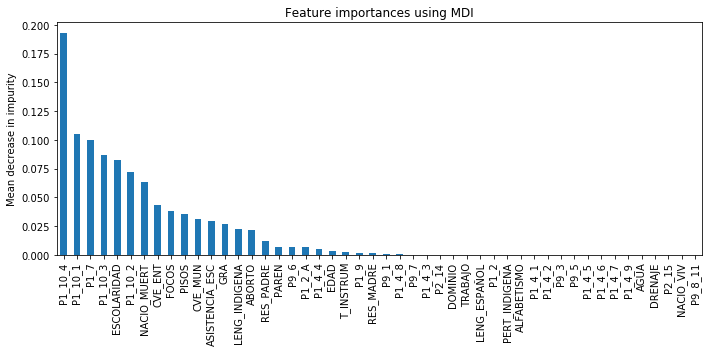

In [20]:
forest_importances = pd.Series(importances, index=df_SS.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
#forest_importances[:15].plot.bar(yerr=std, ax=ax)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [21]:
textfile = open("FI/Abuso_feature_importance_RF_SS.txt", "w")
for element in importances:
    textfile.write(str(element) + "\n")
textfile.close()

### MINMAXSCALER

In [22]:
%time resultados, importances = grid(param_grid, df_MMS, y)

Creando modelos para 1 combinaciones de parámetros.

Fitting 5 folds for each of 6600 candidates, totalling 33000 fits
CPU times: user 6h 24min 6s, sys: 43.4 s, total: 6h 24min 49s
Wall time: 6h 24min 49s


In [23]:
resultados.head(5)

,f1,criterion,max_depth,min_samples_leaf,min_samples_split,n_estimators,random_state
0,1.0,gini,6,150,285,120,5


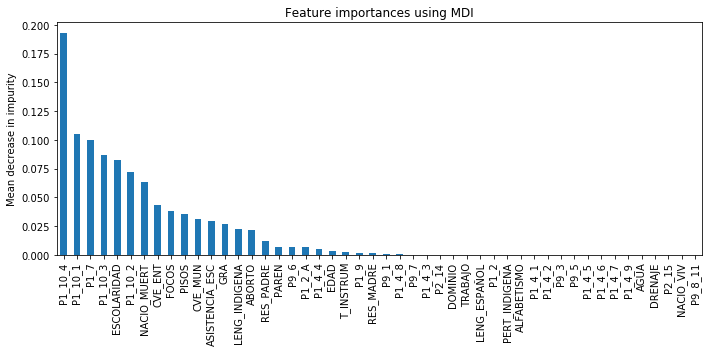

In [24]:
forest_importances = pd.Series(importances, index=df_MMS.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
#forest_importances[:15].plot.bar(yerr=std, ax=ax)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [25]:
textfile = open("FI/Abuso_feature_importance_RF_MMS.txt", "w")
for element in importances:
    textfile.write(str(element) + "\n")
textfile.close()

## ORIGINAL

In [26]:
%time resultados, importances = grid(param_grid, endireh, y)

Creando modelos para 1 combinaciones de parámetros.

Fitting 5 folds for each of 6600 candidates, totalling 33000 fits
CPU times: user 5h 49min 50s, sys: 34.9 s, total: 5h 50min 25s
Wall time: 5h 50min 24s


In [27]:
resultados.head(5)

,f1,criterion,max_depth,min_samples_leaf,min_samples_split,n_estimators,random_state
0,1.0,gini,6,150,285,120,5


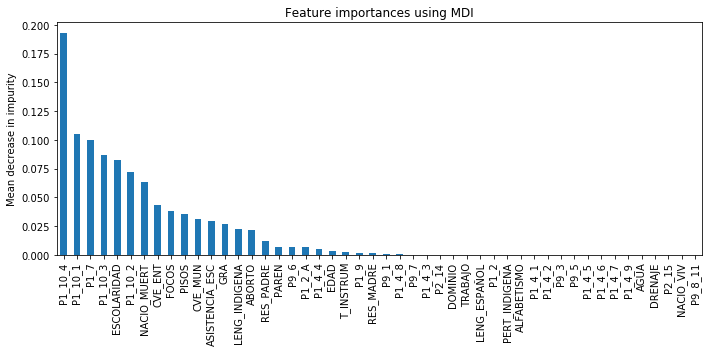

In [28]:
forest_importances = pd.Series(importances, index=endireh.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
#forest_importances[:15].plot.bar(yerr=std, ax=ax)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [29]:
textfile = open("FI/Abuso_feature_importance_RF_Org.txt", "w")
for element in importances:
    textfile.write(str(element) + "\n")
textfile.close()

In [30]:
sum(forest_importances)

0.9999999999999999

In [31]:
forest_importances

P1_10_4           0.192543
P1_10_1           0.105340
P1_7              0.099699
P1_10_3           0.086715
ESCOLARIDAD       0.082203
P1_10_2           0.071938
NACIO_MUERT       0.063254
CVE_ENT           0.043553
FOCOS             0.038083
PISOS             0.035802
CVE_MUN           0.031000
ASISTENCIA_ESC    0.029731
GRA               0.026793
LENG_INDIGENA     0.022084
ABORTO            0.021473
RES_PADRE         0.012213
PAREN             0.007189
P9_6              0.006988
P1_2_A            0.006936
P1_4_4            0.004813
EDAD              0.003538
T_INSTRUM         0.002296
P1_9              0.001846
RES_MADRE         0.001765
P9_1              0.001122
P1_4_8            0.001083
P9_7              0.000000
P1_4_3            0.000000
P2_14             0.000000
DOMINIO           0.000000
TRABAJO           0.000000
LENG_ESPAÑOL      0.000000
P1_2              0.000000
PERT_INDIGENA     0.000000
ALFABETISMO       0.000000
P1_4_1            0.000000
P1_4_2            0.000000
P